# digest2 Ground-Truth Evaluation Tutorial

This notebook demonstrates how to evaluate digest2 classification results against
known ground-truth orbital data using the `digest2.truth` module.

## Overview

When testing digest2 on a labelled dataset (e.g., known asteroids submitted as
anonymous tracklets), you want to measure how accurately the classifier identifies
each orbit class.  The `digest2.truth` module provides:

1. **Ground-truth file loading** — load known orbital elements (q, e, i, H) and
   automatically derive orbit class labels using the same boundary definitions
   as the C scoring engine.
2. **Trksub-to-designation mapping** — link anonymous tracklet IDs in the
   digest2 output to known object designations.
3. **Evaluation metrics** — confusion matrices, binary detection metrics
   (precision, recall, F1), score distributions, and threshold sweeps.
4. **Diagnostic plots** — heatmap confusion matrices, score histograms,
   precision/recall curves, and per-class F1 bar charts.

## Requirements

This notebook requires `digest2` and `matplotlib`.  The cell below
ensures `matplotlib` is installed in the current kernel environment.

In [ ]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "matplotlib"])

## 1. Imports

In [26]:
import tempfile
import os

from digest2.result import ClassificationResult, Scores
from digest2.truth import (
    classify_orbit,
    classify_orbit_all,
    GroundTruthRecord,
    load_ground_truth,
    load_trksub_mapping,
    TruthEvaluator,
)

import matplotlib.pyplot as plt

print("Imports successful.")

Imports successful.


## 2. Classifying Orbits from Orbital Elements

Before working with files, let's see how `classify_orbit` maps orbital elements
to the digest2 orbit class labels.

The function uses the same boundary definitions as the C scoring engine
(from `population.py`).  For example, an object with q < 1.3 AU is classified
as a Near-Earth Object (NEO).

In [27]:
# NEO: q < 1.3 AU
print(f"NEO orbit:  {classify_orbit(q=0.9, e=0.4, i=10.0, H=20.0)=}")

# Mars Crosser: 1.3 <= q < 1.67, Q > 1.58
print(f"MC orbit:   {classify_orbit(q=1.4, e=0.35, i=10.0, H=18.0)=}")

# Inner Main Belt
print(f"MB1 orbit:  {classify_orbit(q=1.8, e=0.18, i=5.0, H=17.0)=}")

# Middle Main Belt
print(f"MB2 orbit:  {classify_orbit(q=2.0, e=0.25, i=8.0, H=15.0)=}")

# Outer Main Belt
print(f"MB3 orbit:  {classify_orbit(q=3.0, e=0.05, i=5.0, H=13.0)=}")

# Jupiter Family Comet
print(f"JFC orbit:  {classify_orbit(q=1.5, e=0.60, i=12.0, H=15.0)=}")

NEO orbit:  classify_orbit(q=0.9, e=0.4, i=10.0, H=20.0)='NEO'
MC orbit:   classify_orbit(q=1.4, e=0.35, i=10.0, H=18.0)='MC'
MB1 orbit:  classify_orbit(q=1.8, e=0.18, i=5.0, H=17.0)='MB1'
MB2 orbit:  classify_orbit(q=2.0, e=0.25, i=8.0, H=15.0)='MB2'
MB3 orbit:  classify_orbit(q=3.0, e=0.05, i=5.0, H=13.0)='MB3'
JFC orbit:  classify_orbit(q=1.5, e=0.60, i=12.0, H=15.0)='JFC'


In [28]:
# classify_orbit_all returns ALL matching classes for an orbit
# (an orbit can belong to multiple overlapping classes)
neo_classes = classify_orbit_all(q=0.9, e=0.4, i=10.0, H=20.0)
print(f"NEO orbit matches: {neo_classes}")
# An NEO with H=20 matches: Int, NEO, N22 (and possibly N18 if H <= 18)

NEO orbit matches: ['Int', 'NEO', 'N22']


## 3. Creating Sample Data Files

In a real workflow you would have:
- A **ground-truth CSV** with known orbital elements for each object
- A **trksub mapping CSV** linking tracklet IDs to object designations
- **digest2 classification results** from running `Digest2.classify_file()`

For this tutorial, we create synthetic data to demonstrate the workflow.

Note that the trksub mapping is **many-to-one**: a single object can produce
multiple tracklets (e.g., observed on different nights), so several trksubs
can map to the same designation.  This is the typical real-world situation
and the evaluator handles it correctly — each tracklet is evaluated
independently against the ground truth for its parent object.

In [29]:
# Create a temporary directory for our sample files
tmpdir = tempfile.mkdtemp()

# === Ground-truth CSV ===
# Each row: designation, q, e, i, H
# The orbit_type will be auto-derived from the orbital elements
truth_csv_path = os.path.join(tmpdir, "ground_truth.csv")
with open(truth_csv_path, "w") as f:
    f.write("designation,q,e,i,H\n")
    # NEOs
    f.write("2024 AA,0.90,0.40,10.0,20.0\n")
    f.write("2024 AB,0.85,0.50,15.0,22.0\n")
    f.write("2024 AC,1.10,0.30,8.0,19.0\n")
    f.write("2024 AD,0.70,0.60,5.0,21.0\n")
    # Mars Crossers
    f.write("2024 BA,1.40,0.35,10.0,18.0\n")
    f.write("2024 BB,1.50,0.30,12.0,17.0\n")
    # Inner Main Belt (MB1)
    f.write("2024 CA,1.80,0.18,5.0,17.0\n")
    f.write("2024 CB,1.85,0.15,4.0,16.0\n")
    f.write("2024 CC,1.75,0.20,6.0,18.0\n")
    # Middle Main Belt (MB2)
    f.write("2024 DA,2.00,0.25,8.0,15.0\n")
    f.write("2024 DB,2.10,0.20,10.0,14.0\n")
    f.write("2024 DC,1.95,0.28,7.0,16.0\n")
    # Outer Main Belt (MB3)
    f.write("2024 EA,3.00,0.05,5.0,13.0\n")
    f.write("2024 EB,2.90,0.10,8.0,12.0\n")
    # Jupiter Family Comet
    f.write("2024 FA,1.50,0.60,12.0,15.0\n")

print(f"Ground truth CSV written to: {truth_csv_path}")

# === Trksub mapping CSV ===
# Maps tracklet IDs (used in observation files) to designations.
# Note: multiple trksubs can map to the same designation (many-to-one).
# This is typical in practice — the same object is observed on different
# nights, producing separate tracklets that digest2 scores independently.
mapping_csv_path = os.path.join(tmpdir, "trksub_mapping.csv")
with open(mapping_csv_path, "w") as f:
    f.write("trksub,designation\n")
    # 2024 AA (NEO): 1 tracklet
    f.write("T001,2024 AA\n")
    # 2024 AB (NEO): 3 tracklets from different nights
    f.write("T002a,2024 AB\n")
    f.write("T002b,2024 AB\n")
    f.write("T002c,2024 AB\n")
    # 2024 AC (NEO): 1 tracklet
    f.write("T003,2024 AC\n")
    # 2024 AD (NEO): 2 tracklets
    f.write("T004a,2024 AD\n")
    f.write("T004b,2024 AD\n")
    # 2024 BA (MC): 1 tracklet
    f.write("T005,2024 BA\n")
    # 2024 BB (MC): 2 tracklets
    f.write("T006a,2024 BB\n")
    f.write("T006b,2024 BB\n")
    # MB1: 1 tracklet each
    f.write("T007,2024 CA\n")
    f.write("T008,2024 CB\n")
    f.write("T009,2024 CC\n")
    # MB2: 1 tracklet each
    f.write("T010,2024 DA\n")
    f.write("T011,2024 DB\n")
    f.write("T012,2024 DC\n")
    # MB3: 1 tracklet each
    f.write("T013,2024 EA\n")
    f.write("T014,2024 EB\n")
    # JFC: 1 tracklet
    f.write("T015,2024 FA\n")

print(f"Trksub mapping written to: {mapping_csv_path}")

Ground truth CSV written to: /var/folders/67/j23cbc8x5r3b_1cy48v0rf4m0000gq/T/tmpge_5isbj/ground_truth.csv
Trksub mapping written to: /var/folders/67/j23cbc8x5r3b_1cy48v0rf4m0000gq/T/tmpge_5isbj/trksub_mapping.csv


## 4. Loading Ground Truth

Load the CSV files and inspect the derived orbit classifications.

In [30]:
# Load ground truth
ground_truth = load_ground_truth(truth_csv_path)
print(f"Loaded {len(ground_truth)} ground-truth records\n")

# Show the derived orbit types
print(f"{'Designation':<12} {'q':>6} {'e':>6} {'i':>6} {'H':>6}  {'Type':<6} All Classes")
print("-" * 70)
for desig, rec in sorted(ground_truth.items()):
    print(f"{desig:<12} {rec.q:6.2f} {rec.e:6.2f} {rec.i:6.1f} {rec.H:6.1f}  {rec.orbit_type:<6} {rec.all_classes}")

Loaded 15 ground-truth records

Designation       q      e      i      H  Type   All Classes
----------------------------------------------------------------------
2024 AA        0.90   0.40   10.0   20.0  NEO    ['Int', 'NEO', 'N22']
2024 AB        0.85   0.50   15.0   22.0  NEO    ['Int', 'NEO', 'N22']
2024 AC        1.10   0.30    8.0   19.0  NEO    ['Int', 'NEO', 'N22']
2024 AD        0.70   0.60    5.0   21.0  NEO    ['Int', 'NEO', 'N22']
2024 BA        1.40   0.35   10.0   18.0  MC     ['MC']
2024 BB        1.50   0.30   12.0   17.0  MC     ['MC']
2024 CA        1.80   0.18    5.0   17.0  MB1    ['MB1']
2024 CB        1.85   0.15    4.0   16.0  MB1    ['MB1']
2024 CC        1.75   0.20    6.0   18.0  MB1    ['MB1']
2024 DA        2.00   0.25    8.0   15.0  MB2    ['MB2']
2024 DB        2.10   0.20   10.0   14.0  MB2    ['MB2']
2024 DC        1.95   0.28    7.0   16.0  MB2    ['MB2']
2024 EA        3.00   0.05    5.0   13.0  MB3    ['MB3']
2024 EB        2.90   0.10    8.0   12.0 

In [31]:
# Load trksub mapping
mapping = load_trksub_mapping(mapping_csv_path)
print(f"Loaded {len(mapping)} trksub mappings\n")

# Show the many-to-one relationship: multiple trksubs -> same designation
from collections import defaultdict
desig_to_trksubs = defaultdict(list)
for trksub, desig in mapping.items():
    desig_to_trksubs[desig].append(trksub)

for desig in sorted(desig_to_trksubs):
    trksubs = desig_to_trksubs[desig]
    if len(trksubs) > 1:
        print(f"{desig}: {len(trksubs)} tracklets -> {trksubs}")
    else:
        print(f"{desig}: {len(trksubs)} tracklet  -> {trksubs}")

Loaded 19 trksub mappings

2024 AA: 1 tracklet  -> ['T001']
2024 AB: 3 tracklets -> ['T002a', 'T002b', 'T002c']
2024 AC: 1 tracklet  -> ['T003']
2024 AD: 2 tracklets -> ['T004a', 'T004b']
2024 BA: 1 tracklet  -> ['T005']
2024 BB: 2 tracklets -> ['T006a', 'T006b']
2024 CA: 1 tracklet  -> ['T007']
2024 CB: 1 tracklet  -> ['T008']
2024 CC: 1 tracklet  -> ['T009']
2024 DA: 1 tracklet  -> ['T010']
2024 DB: 1 tracklet  -> ['T011']
2024 DC: 1 tracklet  -> ['T012']
2024 EA: 1 tracklet  -> ['T013']
2024 EB: 1 tracklet  -> ['T014']
2024 FA: 1 tracklet  -> ['T015']


## 5. Simulating digest2 Results

In a real workflow, you would run the `classify()` function on your observation data: For examples of how to run `classify()`, please see the `mpc_tutorial_digest2.ipynb` notebook. 

Here we do not directly call the `classify()` function, but instead create some synthetic `ClassificationResult` objects that simulate a mix of correct and incorrect classifications.

In [32]:
def make_result(trksub, neo=0, mc=0, mb1=0, mb2=0, mb3=0, jfc=0, **kw):
    """Helper to create a ClassificationResult with specified scores."""
    return ClassificationResult(
        raw=Scores(NEO=neo, MC=mc, MB1=mb1, MB2=mb2, MB3=mb3, JFC=jfc, **kw),
        noid=Scores(NEO=neo, MC=mc, MB1=mb1, MB2=mb2, MB3=mb3, JFC=jfc, **kw),
        rms=0.5,
        rms_prime=0.0,
        designation=trksub,
    )

# Simulate results — a realistic mix of correct and incorrect classifications.
# Note: objects with multiple tracklets get a result per tracklet.
# Scores may vary between tracklets of the same object (different
# arc lengths, observing conditions, etc.).
simulated_results = [
    # --- NEOs ---
    # 2024 AA: 1 tracklet, correctly identified
    make_result("T001", neo=88, mc=5, mb1=3),
    #
    # 2024 AB: 3 tracklets from different nights — scores vary!
    make_result("T002a", neo=75, mc=10, mb1=8),          # night 1: correct
    make_result("T002b", neo=40, mc=25, mb1=20),         # night 2: MISSED (short arc)
    make_result("T002c", neo=91, mc=3, mb1=2),           # night 3: correct (longer arc)
    #
    # 2024 AC: 1 tracklet, correctly identified
    make_result("T003", neo=92, mc=3, mb1=2),
    #
    # 2024 AD: 2 tracklets
    make_result("T004a", neo=45, mc=20, mb1=15),         # night 1: MISSED (below threshold)
    make_result("T004b", neo=82, mc=8, mb1=5),           # night 2: correct (better arc)
    #
    # --- Mars Crossers ---
    # 2024 BA: 1 tracklet, correct
    make_result("T005", neo=8, mc=72, mb1=12),
    #
    # 2024 BB: 2 tracklets
    make_result("T006a", neo=70, mc=15, mb1=8),          # night 1: misclassified as NEO!
    make_result("T006b", neo=12, mc=68, mb1=10),         # night 2: correct
    #
    # --- MB1 ---
    make_result("T007", neo=3, mc=5, mb1=82),            # 2024 CA: correct
    make_result("T008", neo=2, mc=3, mb1=88),            # 2024 CB: correct
    make_result("T009", neo=5, mc=8, mb1=75),            # 2024 CC: correct
    #
    # --- MB2 ---
    make_result("T010", neo=2, mc=3, mb1=10, mb2=78),    # 2024 DA: correct
    make_result("T011", neo=1, mc=2, mb1=15, mb2=72),    # 2024 DB: correct
    make_result("T012", neo=3, mc=5, mb1=68, mb2=15),    # 2024 DC: misclassified as MB1!
    #
    # --- MB3 ---
    make_result("T013", neo=1, mc=1, mb1=5, mb2=8, mb3=80),   # 2024 EA: correct
    make_result("T014", neo=0, mc=1, mb1=3, mb2=10, mb3=78),  # 2024 EB: correct
    #
    # --- JFC ---
    make_result("T015", neo=10, mc=5, mb1=3, jfc=70),    # 2024 FA: correct
]

print(f"Created {len(simulated_results)} simulated classification results")
print(f"  (from {len(ground_truth)} unique objects, some with multiple tracklets)")

Created 19 simulated classification results
  (from 15 unique objects, some with multiple tracklets)


## 6. Creating the TruthEvaluator

The `TruthEvaluator` takes the digest2 results, ground truth, and mapping,
then provides methods for analysis.

In [33]:
evaluator = TruthEvaluator(
    results=simulated_results,
    ground_truth=ground_truth,
    trksub_mapping=mapping,
    threshold=65.0,     # Score threshold for binary classification
    score_type="noid",  # Use NoID scores (default)
)

print(f"Matched:   {len(evaluator.matched)} results")
print(f"Unmatched: {len(evaluator.unmatched_results)} results")

Matched:   19 results
Unmatched: 0 results


## 7. Summary Statistics

In [34]:
summary = evaluator.summary()

print("=== Evaluation Summary ===")
print(f"Total results:        {summary['total_results']}")
print(f"Matched to truth:     {summary['matched']}")
print(f"Unmatched:            {summary['unmatched']}")
print(f"Top-class accuracy:   {summary['top_class_accuracy']:.1%}")
print(f"Overall accuracy:     {summary['overall_accuracy']:.1%}")
print(f"\nTrue class distribution:")
for cls, count in sorted(summary['true_class_distribution'].items()):
    print(f"  {cls}: {count}")

=== Evaluation Summary ===
Total results:        19
Matched to truth:     19
Unmatched:            0
Top-class accuracy:   89.5%
Overall accuracy:     89.5%

True class distribution:
  JFC: 1
  MB1: 3
  MB2: 3
  MB3: 2
  MC: 3
  NEO: 7


## 8. Confusion Matrix

The confusion matrix shows how true classes map to predicted classes.
Ideally, all counts should be on the diagonal.

In [35]:
# Numerical confusion matrix
cm = evaluator.confusion_matrix()

print(f"Labels: {cm['labels']}\n")
header = 'True \\ Pred'
print(f"{header:<10}", end="")
for label in cm['labels']:
    print(f"{label:>6}", end="")
print()
print("-" * (10 + 6 * len(cm['labels'])))
for i, true_label in enumerate(cm['labels']):
    print(f"{true_label:<10}", end="")
    for j in range(len(cm['labels'])):
        print(f"{cm['matrix'][i][j]:>6}", end="")
    print()

Labels: ['NEO', 'MC', 'MB1', 'MB2', 'MB3', 'JFC']

True \ Pred   NEO    MC   MB1   MB2   MB3   JFC
----------------------------------------------
NEO            7     0     0     0     0     0
MC             1     2     0     0     0     0
MB1            0     0     3     0     0     0
MB2            0     0     1     2     0     0
MB3            0     0     0     0     2     0
JFC            0     0     0     0     0     1


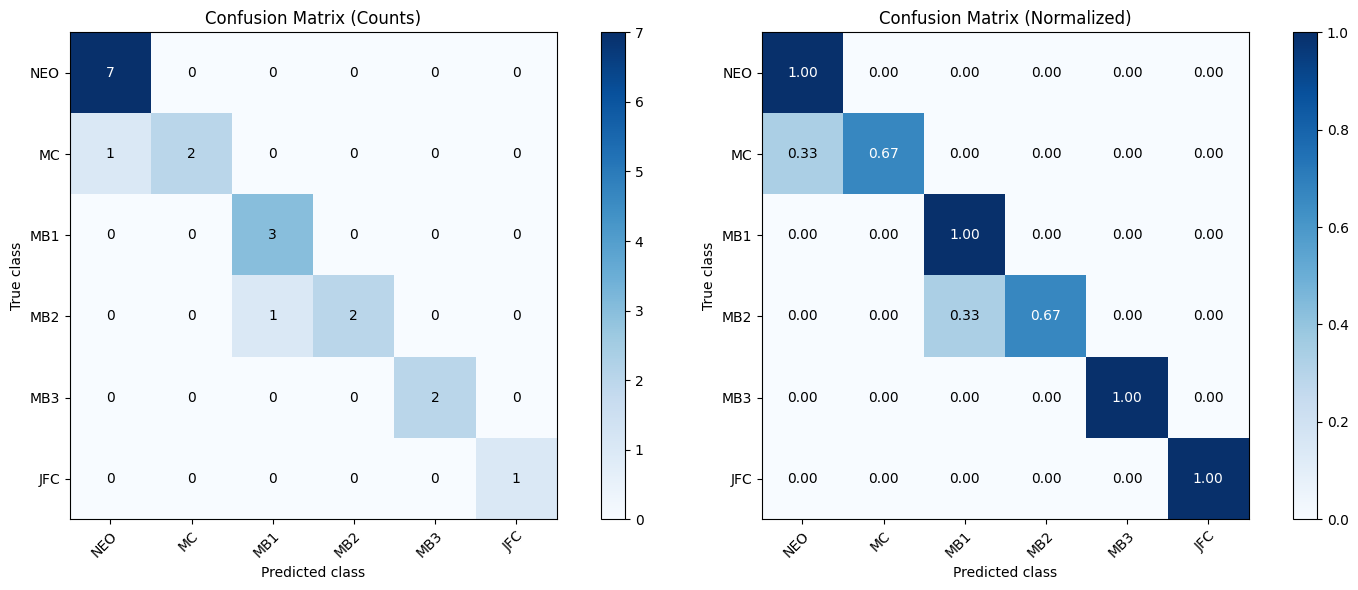

In [36]:
# Plot the confusion matrix as a heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

evaluator.plot_confusion_matrix(ax=axes[0], title="Confusion Matrix (Counts)")
evaluator.plot_confusion_matrix(ax=axes[1], normalize=True,
                                 title="Confusion Matrix (Normalized)")

plt.tight_layout()

## 9. Binary Detection Metrics (NEO Focus)

For NEO detection, the key question is: how many true NEOs does digest2
correctly flag (recall), and how many non-NEOs get falsely flagged (precision)?

In [37]:
neo_metrics = evaluator.binary_metrics("NEO")

print("=== NEO Detection Metrics (threshold=65) ===")
print(f"True Positives:  {neo_metrics['tp']:>3}  (NEOs correctly flagged)")
print(f"False Positives: {neo_metrics['fp']:>3}  (non-NEOs incorrectly flagged)")
print(f"True Negatives:  {neo_metrics['tn']:>3}  (non-NEOs correctly ignored)")
print(f"False Negatives: {neo_metrics['fn']:>3}  (NEOs missed)")
print(f"")
print(f"Precision:       {neo_metrics['precision']:.3f}")
print(f"Recall:          {neo_metrics['recall']:.3f}")
print(f"F1 Score:        {neo_metrics['f1']:.3f}")
print(f"Accuracy:        {neo_metrics['accuracy']:.3f}")

=== NEO Detection Metrics (threshold=65) ===
True Positives:    5  (NEOs correctly flagged)
False Positives:   1  (non-NEOs incorrectly flagged)
True Negatives:   11  (non-NEOs correctly ignored)
False Negatives:   2  (NEOs missed)

Precision:       0.833
Recall:          0.714
F1 Score:        0.769
Accuracy:        0.842


## 10. Per-Class Accuracy Table

Compare detection performance across all orbit classes.

In [38]:
table = evaluator.per_class_accuracy(
    classes=["NEO", "MC", "MB1", "MB2", "MB3", "JFC"]
)

print(f"{'Class':<6} {'TP':>4} {'FP':>4} {'FN':>4} {'TN':>4}  {'Prec':>6} {'Rec':>6} {'F1':>6}")
print("-" * 52)
for row in table:
    print(f"{row['class']:<6} {row['tp']:>4} {row['fp']:>4} {row['fn']:>4} {row['tn']:>4}  "
          f"{row['precision']:>6.3f} {row['recall']:>6.3f} {row['f1']:>6.3f}")

Class    TP   FP   FN   TN    Prec    Rec     F1
----------------------------------------------------
NEO       5    1    2   11   0.833  0.714  0.769
MC        2    0    2   15   1.000  0.500  0.667
MB1       3    1    0   15   0.750  1.000  0.857
MB2       2    0    1   16   1.000  0.667  0.800
MB3       2    0    0   17   1.000  1.000  1.000
JFC       1    0    0   18   1.000  1.000  1.000


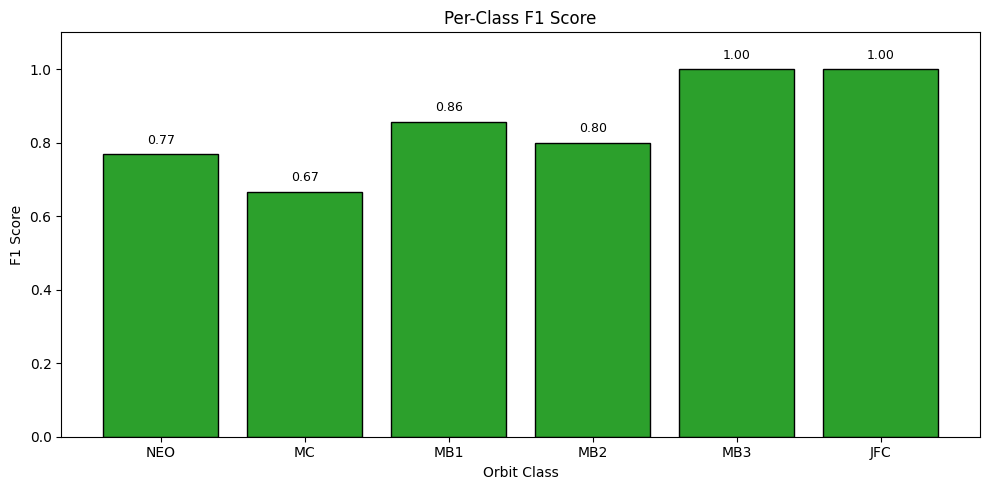

In [39]:
# Plot per-class F1 scores
ax = evaluator.plot_per_class_f1(
    classes=["NEO", "MC", "MB1", "MB2", "MB3", "JFC"]
)
None  # display inline

## 11. Score Distributions

Visualize how digest2 NEO scores are distributed for true NEOs vs non-NEOs.
Ideally, the distributions should be well-separated.

In [40]:
# Get the raw score data
dist = evaluator.score_distributions("NEO")
print(f"True NEO scores:     {dist['true_positive_scores']}")
print(f"True non-NEO scores: {dist['true_negative_scores']}")

True NEO scores:     [88, 75, 40, 91, 92, 45, 82]
True non-NEO scores: [8, 70, 12, 3, 2, 5, 2, 1, 3, 1, 0, 10]


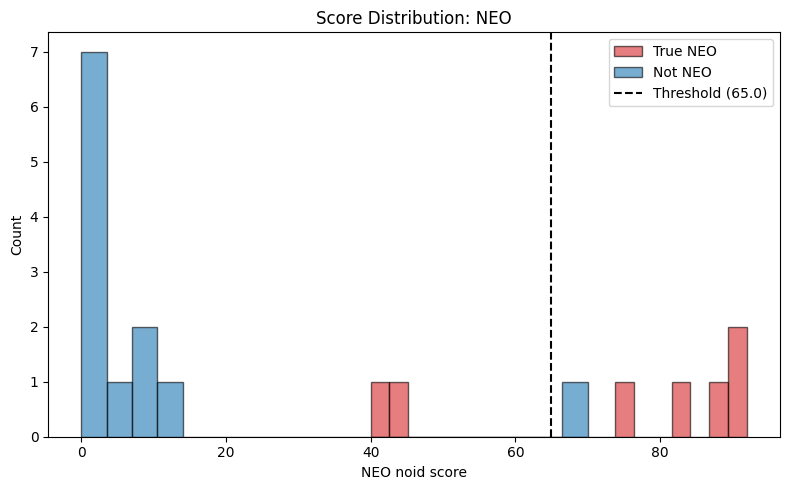

In [41]:
# Plot score distributions
ax = evaluator.plot_score_distribution("NEO")
None  # display inline

## 12. Threshold Sweep

How does NEO detection performance change across different thresholds?
This helps you find the optimal balance between precision and recall.

In [42]:
# Sweep thresholds and show a few key points
sweep = evaluator.threshold_sweep("NEO", thresholds=[0, 25, 50, 65, 75, 90, 100])

print(f"{'Thresh':>6} {'Prec':>6} {'Rec':>6} {'F1':>6} {'TP':>4} {'FP':>4} {'FN':>4}")
print("-" * 40)
for s in sweep:
    print(f"{s['threshold']:>6.0f} {s['precision']:>6.3f} {s['recall']:>6.3f} "
          f"{s['f1']:>6.3f} {s['tp']:>4} {s['fp']:>4} {s['fn']:>4}")

Thresh   Prec    Rec     F1   TP   FP   FN
----------------------------------------
     0  0.368  1.000  0.538    7   12    0
    25  0.875  1.000  0.933    7    1    0
    50  0.833  0.714  0.769    5    1    2
    65  0.833  0.714  0.769    5    1    2
    75  1.000  0.714  0.833    5    0    2
    90  1.000  0.286  0.444    2    0    5
   100  0.000  0.000  0.000    0    0    7


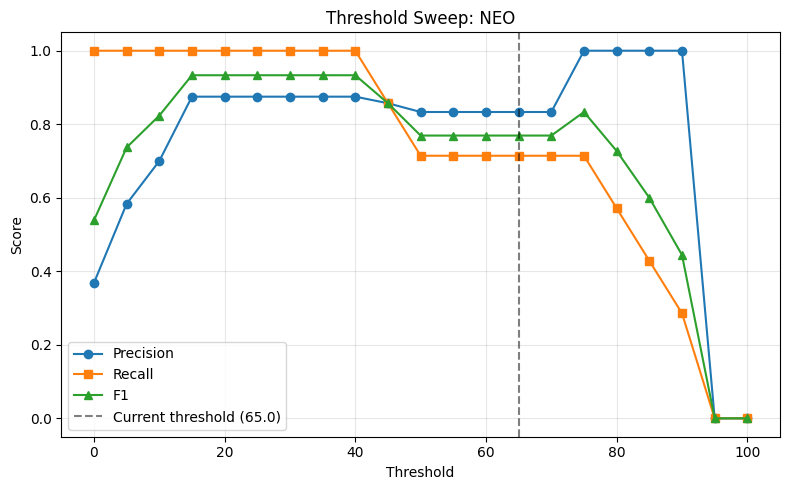

In [43]:
# Plot the threshold sweep
ax = evaluator.plot_threshold_sweep("NEO")
None  # display inline

## 13. Investigating Misclassifications

Drill down into specific objects that were misclassified.

In [44]:
# False negatives: true NEOs that digest2 missed (score < threshold)
fn = evaluator.misclassified("NEO", kind="fn")
print(f"=== NEO False Negatives ({len(fn)} missed) ===")
for m in fn:
    score = m.result.noid.NEO
    print(f"  {m.trksub} ({m.designation}): NEO score = {score:.0f}, "
          f"true class = {m.true_class}, "
          f"q={m.truth.q:.2f}, e={m.truth.e:.2f}, i={m.truth.i:.1f}")

=== NEO False Negatives (2 missed) ===
  T002b (2024 AB): NEO score = 40, true class = NEO, q=0.85, e=0.50, i=15.0
  T004a (2024 AD): NEO score = 45, true class = NEO, q=0.70, e=0.60, i=5.0


In [45]:
# False positives: non-NEOs that digest2 flagged as NEO
fp = evaluator.misclassified("NEO", kind="fp")
print(f"=== NEO False Positives ({len(fp)} false alarms) ===")
for m in fp:
    score = m.result.noid.NEO
    print(f"  {m.trksub} ({m.designation}): NEO score = {score:.0f}, "
          f"true class = {m.true_class}, "
          f"q={m.truth.q:.2f}, e={m.truth.e:.2f}, i={m.truth.i:.1f}")

=== NEO False Positives (1 false alarms) ===
  T006a (2024 BB): NEO score = 70, true class = MC, q=1.50, e=0.30, i=12.0


## 14. Summary

The `digest2.truth` module provides a complete evaluation workflow:

1. **`load_ground_truth()`** — Load known orbital elements from CSV and
   automatically derive orbit class labels.
2. **`load_trksub_mapping()`** — Link tracklet IDs to object designations.
3. **`classify_orbit()` / `classify_orbit_all()`** — Classify orbits using
   the same boundaries as the C scoring engine.
4. **`TruthEvaluator`** — Match digest2 results to ground truth and compute:
   - `summary()` — overall accuracy
   - `confusion_matrix()` — true vs predicted class counts
   - `binary_metrics()` — TP/FP/FN/TN, precision, recall, F1
   - `per_class_accuracy()` — metrics for each orbit class
   - `score_distributions()` — score histograms by true label
   - `threshold_sweep()` — metrics across threshold range
   - `misclassified()` — inspect individual errors
5. **Plotting methods** — `plot_confusion_matrix()`, `plot_score_distribution()`,
   `plot_threshold_sweep()`, `plot_per_class_f1()`

In [46]:
# Cleanup
import shutil
shutil.rmtree(tmpdir)
print("Temporary files cleaned up.")
print("Tutorial complete!")

Temporary files cleaned up.
Tutorial complete!
